# Histology quantitations associations with CTAPs
### Michelle Curtis

### 2023-04-17

In this notebook, we subset fragments into high and low density groups and analyze high density fragment associations with CTAPs.

In [1]:
library(tidyverse)
library(pheatmap)
library(RColorBrewer)
library(grid)
library(readxl)
library(ggtext)
library(rstatix)
library(patchwork)

# set figure size
fig.size <- function(height = 4, width = 4){
    options(repr.plot.height = height, repr.plot.width = width)
}

meta_colors = list(

    "cell_type" = c(
        "B cell/plasma cell" = "#FDBF6F",
        "DC" = "#CAB2D6",
        "Fibroblast" = "#08519C",
        "Endothelial cell" = "#A6CEE3",
        "Macrophage" = "#6A3D9A",
        "T cell" = "#B2DF8A",
        "NK" = "#33A02C"
    ),

    "ctap" = c(
        "M" = "#9E0142",
        "T + M" = "#F46D43",
        "T + B" = "#FEE08B",
        "T + F" = "#E6F598",
        "F" = "#ABDDA4",
        "E + F + M" = "#66C2A5"
    )
)

meta_colors_plot = list('CTAP' = meta_colors$ctap)
names(meta_colors_plot$CTAP) = names(meta_colors_plot$CTAP) %>% str_replace_all('[ + ]', '')


── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.8     ✔ dplyr   1.1.0
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘RColorBrewer’ was built under R version 4.1.3”
Warning message:
“package ‘readxl’ was built under R version 4.1.3”

Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




In [2]:
IFquant = read_delim('../../data/AMP2IFquantificationperfragment04112022.txt')  %>% as.data.frame
IFquant = IFquant %>% mutate(SampleID = str_replace(SampleID, " ", ""))
IFquant = IFquant %>% fill(c('SampleID', 'CTAP (Path)', 'CTAP (Path) T/Mac/Fib'))
rownames(IFquant) = IFquant$FragmentID

IFquant$CTAP = str_split(IFquant[['CTAP (Path)']], ' ') %>% map(1) %>% unlist
IFquant$Path = str_split(IFquant[['CTAP (Path)']], ' ') %>% map(2) %>% unlist %>% str_replace_all('[()]', '')

Rows: 150 Columns: 21
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (4): CTAP (Path), FragmentID, SampleID, CTAP (Path) T/Mac/Fib
dbl (17): CD20/mm2, CD138/mm2, CD3_URMC/mm2, Total cells/mm2 (Rochester), Ti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
# Remove low quality CD3 marker and all CD34+ markers
IFquant = IFquant %>% select(-c(`CD3_URMC/mm2`, 
                                `CD90- CD34+ HLADR- /mm2`, `CD90- CD34+ HLADR+ /mm2`,
                                `CD90+ CD34+ HLADR+ /mm2`
                               ))
IFquant = IFquant %>% rename('CLIC5/mm2' = 'Clic5/mm2', 'CD3/mm2' = 'CD3_UK/mm2')

# Sum all CD90 markers
IFquant[['CD90/mm2']] = IFquant %>% select(starts_with('CD90+')) %>% rowSums
IFquant = IFquant %>% select(-starts_with('CD90+')) 

In [4]:
# Include only marker columns
mark_cols = colnames(IFquant)[grepl('/mm2', colnames(IFquant))]
mark_cols = mark_cols[!grepl('Total', mark_cols)] %>% str_replace('/mm2', '')
colnames(IFquant)[colnames(IFquant) %in% paste0(mark_cols, '/mm2') ] = mark_cols

lymph_marks = c('CD20', 'CD138')
other_marks = setdiff(mark_cols, lymph_marks)

frag_cellcount = IFquant %>% select(all_of(mark_cols))

Quantifications are in units of # positive cells/mm2 for each marker. We can sum all markers to get fragments with high cell density.

In [5]:
# Subset fragments as high/low density per CTAP based on number of marker positive cells
# Where densgroup_CTAP50 == 1 corresponds to high density framgents

IFquant$`Total summed assigned cells/mm2` = rowSums(frag_cellcount)
IFquant$'densgroup_CTAP50' = 0

for (ctap in unique(IFquant$CTAP)){
    ctap_df = IFquant %>% filter(CTAP == ctap)
    qntl = quantile(ctap_df$`Total summed assigned cells/mm2`, 0.5)
    IFquant[rownames(ctap_df), 'densgroup_CTAP50'] = ifelse(ctap_df$`Total summed assigned cells/mm2` >= qntl, 1, 0)
}

IFquant$'densgroup_CTAP50' %>% table

.
 0  1 
74 76 

In [6]:
table(IFquant$CTAP, IFquant$'densgroup_CTAP50')

       
         0  1
  E+F+M  6  6
  F     10 11
  M     17 17
  T+B   19 19
  T+F    5  5
  T+M   17 18

As the two universities stained different fragments for different markers, need to take into account slightly different tissue areas.

In [7]:
IFquant['Total summed assigned cells'] = cbind(IFquant[lymph_marks]*IFquant[['Tissue area (mm2) (Rochester)']],
                                               IFquant[other_marks]*IFquant[['Tissue area (mm2) (Bham)']]) %>% 
                                        rowSums

In [8]:
IFquant %>% head(2)

,CTAP (Path),FragmentID,CD20,CD138,Total cells/mm2 (Rochester),Tissue area (mm2) (Rochester),SampleID,CTAP (Path) T/Mac/Fib,Tissue area (mm2) (Bham),Total cells/mm2 (Bham),CD3,CD68,CLIC5,CD34,CTAP,Path,CD90,Total summed assigned cells/mm2,densgroup_CTAP50,Total summed assigned cells
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
300-309_1,E+F+M (Lym),300-309_1,11.30748,305.3021,8254.464,0.088437,300-309,E+F+M (Lym),1.211100,3085.625,205.59822,25.59657,138.7169,626.7030,E+F+M,Lym,26.42226,1339.6465,1,1267
300-309_1b,E+F+M (Lym),300-309_1b,0.00000,0.0000,5934.161,0.053251,300-309,E+F+M (Lym),0.666689,3151.394,32.99889,11.99960,167.9944,781.4738,E+F+M,Lym,2.99990,997.4666,1,665


In [9]:
# For each fragment, get proportion of total cells positive for a marker 
frag_cellpropcalled = cbind(IFquant[lymph_marks]*IFquant[['Tissue area (mm2) (Rochester)']], 
                           IFquant[other_marks]*IFquant[['Tissue area (mm2) (Bham)']])

frag_cellpropcalled = frag_cellpropcalled[c(lymph_marks, other_marks)]/(IFquant[['Total summed assigned cells']])

frag_cellpropcalled_meta = cbind(IFquant[c('SampleID', 'CTAP', 'Path', 'FragmentID',
                                           'densgroup_CTAP50')], frag_cellpropcalled)

In [10]:
frag_cellpropcalled_meta %>% head(2)

,SampleID,CTAP,Path,FragmentID,densgroup_CTAP50,CD20,CD138,CD3,CD68,CLIC5,CD34,CD90
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
300-309_1,300-309,E+F+M,Lym,300-309_1,1,0.000789266,0.02131018,0.19652723,0.02446725,0.1325967,0.5990529,0.025256511
300-309_1b,300-309,E+F+M,Lym,300-309_1b,1,0.000000000,0.00000000,0.03308271,0.01203008,0.1684211,0.7834586,0.003007519


## Get number of total cells within high/low density groups

In [11]:
# Get % cells corresponding to each group type
group_cellcounts = IFquant %>% group_by(densgroup_CTAP50) %>% 
                    summarise(assigned_sums_CTAP50 = sum(`Total summed assigned cells`))

group_cellcounts = group_cellcounts %>% mutate(assigned_sums_CTAP50 = 
                                               assigned_sums_CTAP50/sum(assigned_sums_CTAP50))

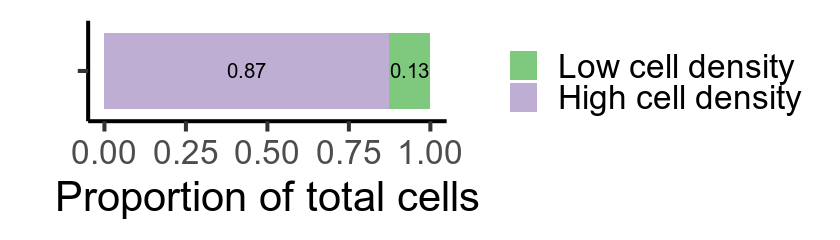

In [12]:
# pdf(file = 'Figures/FigHistoCellProp.pdf', width = 7, height = 2)
fig.size(2, 7)
ggplot(group_cellcounts %>% pivot_longer(cols = c(assigned_sums_CTAP50)) %>% filter(name=='assigned_sums_CTAP50'), 
       aes(x = name, y = value, fill = as.factor(densgroup_CTAP50)))+
    geom_bar(stat = 'identity', position = 'stack')+
    geom_text(aes(x = c(1, 1), y = c(1 - group_cellcounts[[1, 'assigned_sums_CTAP50']]/2, 
                                     group_cellcounts[[2, 'assigned_sums_CTAP50']]/2), 
                  label = round(value, 2)), size = 4.3, col = 'black')+
    theme_classic(base_size = 25)+
    xlab('')+
    ylab('Proportion of total cells')+
    scale_x_discrete(labels=c(''))+
    scale_fill_brewer(palette = 'Accent', labels = c('Low cell density', 'High cell density'))+
    coord_flip()+
    theme(legend.title= element_blank())
# dev.off()

## ANOVA for CTAP associations with markers

In [12]:
mark_cols_final_order = c('CD34', 'CLIC5',  'CD90','CD20', 'CD138', 'CD68', 'CD3')
ctap_plot_order = c('EFM',  'F', 'TF', 'TB', 'TM', 'M')

### High density markers

In [13]:
# Perform anova on just high density fragments
frag_cellpropcalled_meta.aov = frag_cellpropcalled_meta %>% filter(densgroup_CTAP50==1)

anova.res = data.frame(marker = mark_cols_final_order)
anova.res$pval = 1
rownames(anova.res) = anova.res$marker

for (marker in mark_cols_final_order){
    anova = aov(as.formula(paste0(marker, ' ~ ', 'CTAP')), 
                    data = frag_cellpropcalled_meta.aov)
    anova.res[marker, 'pval'] = unlist(summary(anova))[['Pr(>F)1']] 
}

anova.res$padj = anova.res$pval*nrow(anova.res)

In [15]:
anova.res

,marker,pval,padj
,<chr>,<dbl>,<dbl>
CD34,CD34,1.007073e-08,7.049513e-08
CLIC5,CLIC5,7.030682e-04,4.921477e-03
CD90,CD90,7.585814e-02,5.310070e-01
CD20,CD20,4.255826e-03,2.979078e-02
CD138,CD138,1.248465e-01,8.739257e-01
CD68,CD68,1.772731e-03,1.240912e-02
CD3,CD3,7.073336e-03,4.951335e-02


In [14]:
pvals = data.frame(name = mark_cols_final_order)
pvals['significance'] = c('****', '**', '',  '*', '', '*', '*')
pvals$name = factor(pvals$name, levels = mark_cols_final_order)

In [15]:
IFquant_long_propcalled = frag_cellpropcalled_meta %>% pivot_longer(cols = all_of(mark_cols_final_order))
IFquant_long_propcalled = IFquant_long_propcalled %>% mutate(CTAP_plot = str_replace_all(CTAP, '[+]', ''))
IFquant_long_propcalled$CTAP_plot = factor(IFquant_long_propcalled$CTAP_plot, levels = ctap_plot_order)
IFquant_long_propcalled$name = factor(IFquant_long_propcalled$name, levels = mark_cols_final_order)

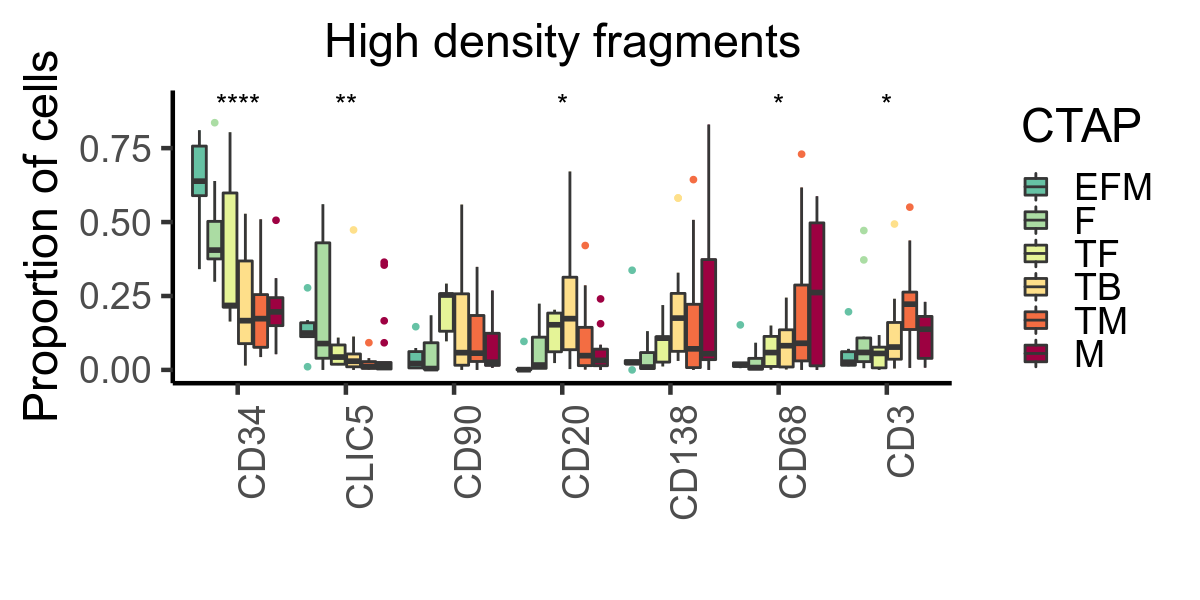

In [16]:
# pdf(file = 'Figures/FigHistoBoxplotHigh.pdf', width = 10, height = 5)
fig.size(5, 10)
group_labels = c('Low density', '')
names(group_labels) = c('0', '1')

ggplot(IFquant_long_propcalled %>% filter(densgroup_CTAP50 == 1))+
    geom_boxplot(aes(x = name, y = value, 
                     fill = CTAP_plot, col = CTAP_plot), 
                 width = .85) +

    geom_boxplot(alpha = 0.01, aes(x = name, y = value, 
                     fill = CTAP_plot, col = CTAP_plot), 
                 width = .85, col = 'grey21', 
                 size = .8, outlier.shape =NA) +
    geom_text(aes(x = name, y= .9, label = significance), size = 6,
             data = pvals)+
    theme_classic(28)+
    scale_fill_manual(values = meta_colors_plot$CTAP)+ #meta_colors$ctap
    scale_color_manual(values = meta_colors_plot$CTAP)+
    theme(axis.text.x = element_text(angle = 90, hjust = 1))+
    xlab('')+
    labs(fill = 'CTAP', col = 'CTAP')+
    ylab('Proportion of cells')+
    guides(fill = guide_legend(reverse = TRUE), col = guide_legend(reverse = TRUE))+
    ggtitle('High density fragments')+
    theme(axis.text.x = element_text(angle = 90, hjust = 1), 
          plot.title = element_text(size = 28, 
                                    hjust = 0.5))
# dev.off()

### Low density markers

In [17]:
# Perform anova on just low density fragments
frag_cellpropcalled_meta_low.aov = frag_cellpropcalled_meta %>% filter(densgroup_CTAP50==0)

anova_low.res = data.frame(marker = mark_cols_final_order)
anova_low.res$pval = 1
rownames(anova_low.res) = anova_low.res$marker

for (marker in mark_cols_final_order){
    anova = aov(as.formula(paste0(marker, ' ~ ', 'CTAP')), 
                    data = frag_cellpropcalled_meta_low.aov)
    anova_low.res[marker, 'pval'] = unlist(summary(anova))[['Pr(>F)1']]
    
}

anova_low.res$padj = anova_low.res$pval*nrow(anova.res)

In [18]:
anova_low.res

,marker,pval,padj
,<chr>,<dbl>,<dbl>
CD34,CD34,0.22249145,1.5574401
CLIC5,CLIC5,0.01805326,0.1263728
CD90,CD90,0.33767648,2.3637353
CD20,CD20,0.71192806,4.9834964
CD138,CD138,0.18031857,1.2622300
CD68,CD68,0.59340545,4.1538381
CD3,CD3,0.18026738,1.2618717


In [21]:
pvals_low = data.frame(name = mark_cols_final_order)
pvals_low['significance'] = rep('', length(mark_cols_final_order))
pvals_low$name = factor(pvals$name, levels = mark_cols_final_order)

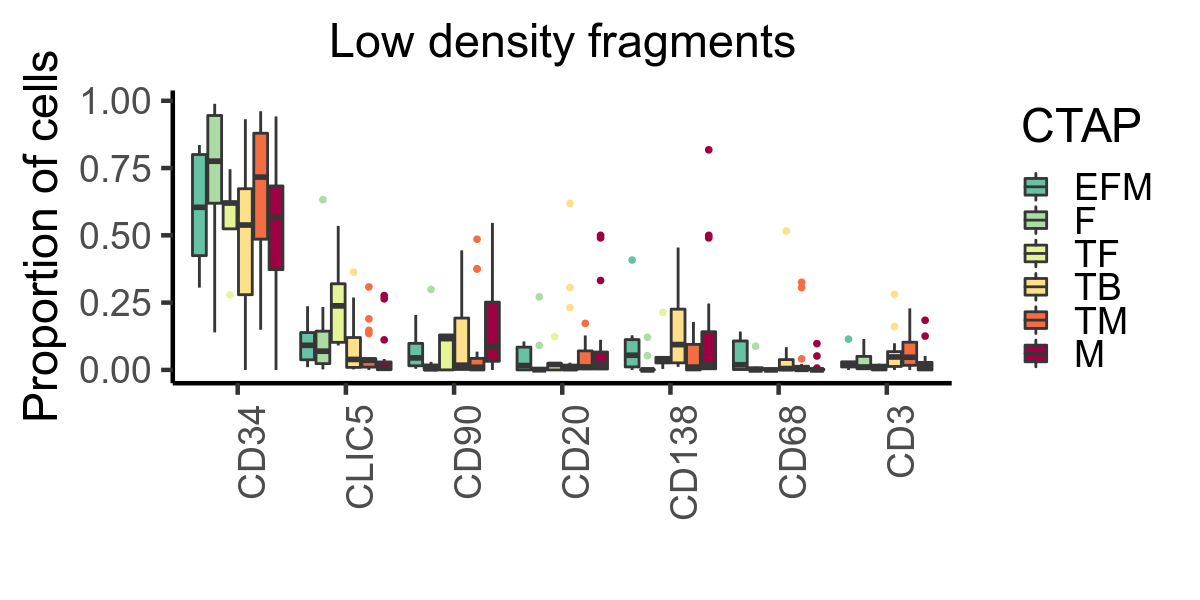

In [22]:
# pdf(file = 'Figures/FigHistoBoxplotLow.pdf', width = 10, height = 5)
fig.size(5, 10)
group_labels = c('Low density', '')
names(group_labels) = c('0', '1')

ggplot(IFquant_long_propcalled %>% filter(densgroup_CTAP50 == 0))+
    geom_boxplot(aes(x = name, y = value, 
                     fill = CTAP_plot, col = CTAP_plot), 
                 width = .85) +

    geom_boxplot(alpha = 0.01, aes(x = name, y = value, 
                     fill = CTAP_plot, col = CTAP_plot), 
                 width = .85, col = 'grey21', 
                 size = .8, outlier.shape =NA) +
    geom_text(aes(x = name, y= .9, label = significance), size = 4,
             data = pvals_low)+
    theme_classic(28)+
    scale_fill_manual(values = meta_colors_plot$CTAP)+ #meta_colors$ctap
    scale_color_manual(values = meta_colors_plot$CTAP)+
    theme(axis.text.x = element_text(angle = 90, hjust = 1))+
    xlab('')+
    labs(fill = 'CTAP', col = 'CTAP')+
    ylab('Proportion of cells')+
    guides(fill = guide_legend(reverse = TRUE), col = guide_legend(reverse = TRUE))+
    ggtitle('Low density fragments')+
    theme(axis.text.x = element_text(angle = 90, hjust = 1), 
          plot.title = element_text(size = 28, 
                                    hjust = 0.5))
# dev.off()

## Heatmap of all marker proportions across fragments

Visualize marker proportions in high density fragments

In [19]:
ctap_order = c('E+F+M',  'F', 'T+F','T+B', 'T+M', 'M')

# Filter to high-density fragments
frag_cellpropcalled_meta_high = frag_cellpropcalled_meta %>% filter(densgroup_CTAP50 ==1)

In [20]:
# Hierarchial cluster fragments within CTAPs 
frag_order_hclust = c()
for (ctap in ctap_order){
    ctap_fragments = rownames(frag_cellpropcalled_meta_high %>% filter(CTAP== ctap))
    ctap_heatmap = pheatmap((frag_cellpropcalled_meta_high %>% select(all_of(mark_cols_final_order)) %>% 
                             scale(center= TRUE, scale = TRUE))[ctap_fragments, ], 
                            cluster_cols = FALSE, silent = TRUE)
    frag_order_hclust = c(frag_order_hclust, ctap_fragments[ctap_heatmap$tree_row$order])
}

In [21]:
meta_colors_plot_heatmap = meta_colors_plot
meta_colors_plot_heatmap$CTAP = meta_colors_plot_heatmap$CTAP %>% rev

max_col = (frag_cellpropcalled_meta_high[frag_order_hclust,] %>% select(mark_cols_final_order) %>% 
           scale(center= TRUE, scale = TRUE)) %>% max
annot_col_high = data.frame(CTAP = frag_cellpropcalled_meta_high[rownames(frag_cellpropcalled_meta_high), 
                                                                 'CTAP'] %>% str_replace_all('[+]', '')) 
rownames(annot_col_high) = rownames(frag_cellpropcalled_meta_high)

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(mark_cols_final_order)

  # Now:
  data %>% select(all_of(mark_cols_final_order))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


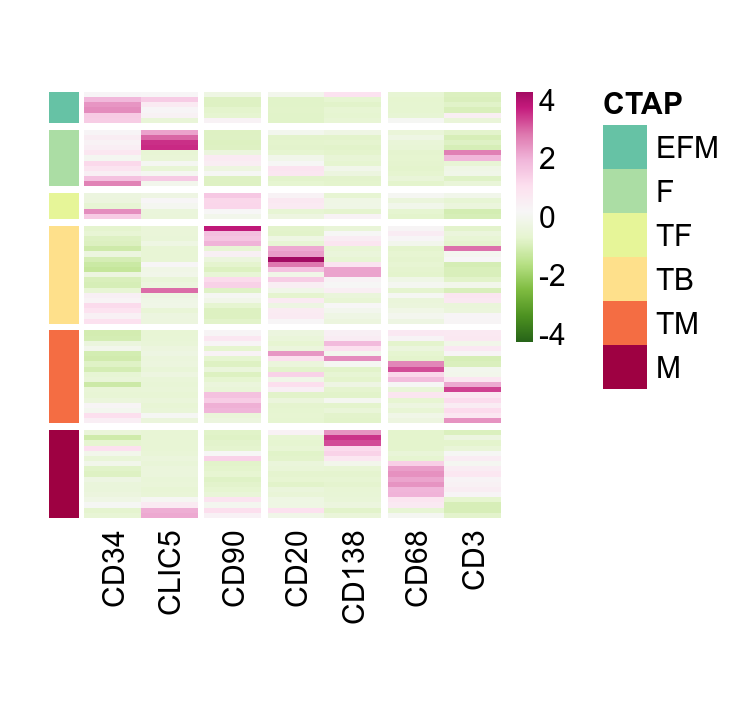

In [26]:
# Column normalize proportions
fig.size(6, 6.3)
p = pheatmap(frag_cellpropcalled_meta_high[frag_order_hclust,] %>% select(mark_cols_final_order) %>% 
             scale(center= TRUE, scale = TRUE),
             annotation_row = annot_col_high, annotation_colors = meta_colors_plot_heatmap, fontsize =18, 
             angle_col = '90',
             cluster_rows = FALSE, cluster_cols = FALSE, border_color = NA, show_rownames = FALSE, 
             gaps_row = cumsum(table(frag_cellpropcalled_meta_high$CTAP)[ctap_order] ),
             gaps_col = c(2,3,5,7 ),
             annotation_names_row =FALSE,
             color = colorRampPalette(brewer.pal(11, "PiYG"))(500) %>% rev,
             breaks = seq(-max_col, max_col, 0.089/5),
             cellwidth = 34, cellheight = 3.1,
             width = 6, height=5)


In [32]:
# pdf('Figures/FigHistoHeatmap.pdf', width = 6.63, height = 6)
# grid::grid.newpage()
# grid::grid.draw(p$gtable)
# grid.text("Fragments", x=.05, y =0.575, rot=90, gp=gpar(fontsize=19))
# grid.text("Column-normalized proportion of cells", x=.39, y =0.91, rot=0, gp=gpar(fontsize=19))
# dev.off()

## Compare with cell type proportions from CITE-seq

Plot correlations of cell type proportions in CITE-seq with marker propotions in histology data.

In [22]:
# Load CITE-seq reference and map of library ID to sample ID
amp_key = read_delim('../../data/220607_AMP _D_BRI key.txt') %>% as.data.frame
colnames(amp_key) = str_replace_all(colnames(amp_key), " ", "_")
amp_key %>% head(2)

amp_ref = readRDS('/data/srlab/ssg34/AMP_RA_references/all_cells_reference.rds')
amp_ref$meta_data %>% head(2)

Rows: 69 Columns: 3
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (3): Subject ID, BRI ID for mRNA library (GEX), BRI ID for protein libra...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


,Subject_ID,BRI_ID_for_mRNA_library_(GEX),BRI_ID_for_protein_library_(ADT)
,<chr>,<chr>,<chr>
1,300-2601,BRI-581,BRI-582
2,300-2657,BRI-603,BRI-604


,cell,sample,cluster_number,cluster_name,cell_type
,<chr>,<chr>,<chr>,<chr>,<chr>
BRI-399_AAACCCAGTGATTCAC,BRI-399_AAACCCAGTGATTCAC,BRI-399,0,E-0: SELP-hi venous,Endothelial cell
BRI-399_AAACGAAAGTACGAGC,BRI-399_AAACGAAAGTACGAGC,BRI-399,0,E-0: SELP-hi venous,Endothelial cell


2 libraries can map to 1 SampleID (this is seen in 3 pairs of samples). Make SampleID name exactly the same for each of these libraries. Combine all batches that correspond to each sample.

In [23]:
# Make SampleID the same for duplicated samples
amp_key = amp_key %>% mutate(SampleID = str_replace(Subject_ID, "-0", "-"))
amp_key = amp_key %>% mutate(SampleID = str_replace(amp_key$SampleID, "V0", "") %>% 
                             str_replace("F1", "") %>% str_replace("F2", ""))

# Filter to samples used in histology
amp_key_filt = amp_key %>% filter(SampleID %in% IFquant$SampleID)
amp_cells = amp_ref$meta_data %>% filter(sample %in% amp_key_filt$`BRI_ID_for_mRNA_library_(GEX)`)

In [29]:
amp_key_filt %>% dim
amp_key %>% dim
IFquant$SampleID %>% unique %>% length
amp_key_filt$SampleID %>% unique %>% length

[1] 39  4

[1] 69  4

[1] 36

[1] 36

In [24]:
dup.samples = amp_key_filt$SampleID[duplicated(amp_key_filt$SampleID)]
amp_key_filt %>% filter(SampleID %in% dup.samples)

Subject_ID,BRI_ID_for_mRNA_library_(GEX),BRI_ID_for_protein_library_(ADT),SampleID
<chr>,<chr>,<chr>,<chr>
300-0462V0,BRI-631,BRI-632,300-462
300-0251F2,BRI-629,BRI-630,300-251
300-0251V0,BRI-627,BRI-628,300-251
300-0462F1,BRI-633R,BRI-634R,300-462
300-0464F1,BRI-637R,BRI-638R,300-464
300-0464V0,BRI-635,BRI-636,300-464


In [25]:
# For each sample, get all cells (with cluster labels) corresponding to the associated libraries
merged_amp = data.frame()

for (samp in amp_key_filt$SampleID) {
    # Get all library IDs, takes into account samples corresponding to multiple libraries
    bri_ids = (amp_key %>% filter(SampleID==samp))[['BRI_ID_for_mRNA_library_(GEX)']]
    merged_df = cbind(`BRI_ID_for_mRNA_library_(GEX)` = (amp_cells %>% filter(sample %in% bri_ids))[['sample']],
                      SampleID = samp, 
                      (amp_cells %>% filter(sample %in% bri_ids) %>% select(-sample)))
    merged_amp = rbind(merged_amp, merged_df)
}
colnames(merged_amp)[1] = 'sample'

# Get CTAP assignments
merged_amp = merge(merged_amp, IFquant[c('SampleID', 'CTAP')] %>% unique, by = 'SampleID', all.x = TRUE)

In [26]:
merged_amp %>% head(2)

,SampleID,sample,cell,cluster_number,cluster_name,cell_type,CTAP
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,300-143,BRI-413,BRI-413_AAAGAACGTAATGCGG,1,E-1: KDR+ capillary,Endothelial cell,F
2,300-143,BRI-413,BRI-413_AACCCAATCTTTCGAT,0,E-0: SELP-hi venous,Endothelial cell,F


In [27]:
# Get cell proportions per sample from IF total cells positive for each marker
# Calculate # of cells positive for each marker per fragment
sample_prop_IF = cbind(IFquant %>% select(SampleID, FragmentID, CTAP, densgroup_CTAP50),
      IFquant[lymph_marks]*IFquant[['Tissue area (mm2) (Rochester)']],
      IFquant[other_marks]*IFquant[['Tissue area (mm2) (Bham)']])

# Subset to only high density fragments
sample_prop_IF = sample_prop_IF %>% filter(densgroup_CTAP50 == 1)
sample_prop_IF = sample_prop_IF %>% 
                group_by(SampleID, CTAP) %>% summarise(across(mark_cols_final_order, sum)) %>%
                as.data.frame

# Convert # of cells to cell proportions
sample_prop_IF[mark_cols_final_order] = (sample_prop_IF[mark_cols_final_order]/
                                         ((sample_prop_IF %>% as.data.frame)[mark_cols_final_order] %>% rowSums))
rownames(sample_prop_IF) = sample_prop_IF$SampleID

`summarise()` has grouped output by 'SampleID'. You can override using the `.groups` argument.


In [28]:
# Number of samples present in both CITE-seq and histology (high-density fragments only)
intersect(rownames(sample_prop_IF), merged_amp$SampleID) %>% length

[1] 23

In [29]:
# Define clusters and markers to compare
plasma_clusters = unique(merged_amp$cluster_name)[grepl('plasma', unique(merged_amp$cluster_name))]
b_clusters = setdiff(unique(merged_amp$cluster_name)[unique(merged_amp$cluster_name) %>% startsWith('B-')],
                    plasma_clusters)

clusters = list('Stromal cell', 'Endothelial cell', 'Myeloid cell', 'T cell',
                'F-2: CD34+ sublining', 'F-3: CLIC5+ lining',
                plasma_clusters, b_clusters)

ctype_col = c(rep('cell_type', 4),
                rep('cluster_name', 4))

markers = list('CD34', 'CD34',  'CD68', 'CD3',
               'CD34', 'CLIC5',
              'CD138', 'CD20')

names_clusters = c('Stromal\n', 'Endothelial\n', 'Myeloid\n', 'T\n',
                'F-2: CD34+\nsublining', 'F-3: CLIC5+\nlining',
                'Plasma\n', 'B\n')

`geom_smooth()` using formula 'y ~ x'



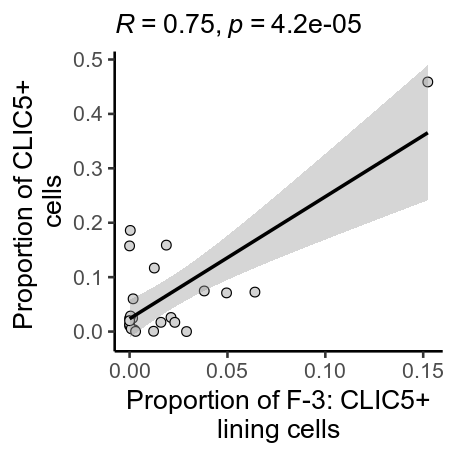

In [32]:
# Define proportion of cells in CITE-seq cluster(s) of interest
cluster_df = merged_amp %>% mutate(prop_cluster = merged_amp[[ctype_col[[i]]]] %in% c(clusters[[i]]))
cluster_df = prop.table(table(cluster_df$SampleID, cluster_df$prop_cluster), 1) %>% unclass %>% as.data.frame

# Subset to samples present in both CITE-seq and histology
cluster_df = cluster_df[intersect(rownames(sample_prop_IF), rownames(cluster_df)), ]
cluster_df[c(markers[[i]])] =  sample_prop_IF[rownames(cluster_df), 
                                                c(markers[[i]])]

# Per sample correlation of proportions in CITE-seq and histology
cortest = cor_test(cluster_df[c(markers[[i]], 'TRUE')], vars = c('TRUE')) 
r = cortest[['cor']] %>% unname

fig.size(3.8, 3.8)
p = ggplot(cluster_df %>% pivot_longer(cols = markers[[i]]), aes(x = `TRUE`, y = value))+
    geom_point(fill = 'lightgrey', shape = 21, size = 2.4)+
    theme_classic(base_size = 16)+
    stat_smooth(method = "lm", col = "black")+
    ylab(paste0('Proportion of ', markers[[i]], '+ \ncells'))+
    xlab(paste0('Proportion of ', names_clusters[[i]], ' cells'))+
    ggtitle(paste0('*R* = ', signif(cortest[['cor']], 2), ', *p* = ', signif(cortest[['p']], 2)))+
    theme(plot.title = ggtext::element_markdown(size = 16))
# plots = c(plots, list(p))
p

In [30]:
plots = list()
for (i in 1:length(clusters)){
    # Define proportion of cells in CITE-seq cluster(s) of interest
    cluster_df = merged_amp %>% mutate(prop_cluster = merged_amp[[ctype_col[[i]]]] %in% c(clusters[[i]]))
    cluster_df = prop.table(table(cluster_df$SampleID, cluster_df$prop_cluster), 1) %>% unclass %>% as.data.frame
    
    # Subset to samples present in both CITE-seq and histology
    cluster_df = cluster_df[intersect(rownames(sample_prop_IF), rownames(cluster_df)), ]
    cluster_df[c(markers[[i]])] =  sample_prop_IF[rownames(cluster_df), 
                                                    c(markers[[i]])]
    
    # Per sample correlation of proportions in CITE-seq and histology
    cortest = cor_test(cluster_df[c(markers[[i]], 'TRUE')], vars = c('TRUE')) 
    r = cortest[['cor']] %>% unname
    
    fig.size(3.8, 3.8)
    p = ggplot(cluster_df %>% pivot_longer(cols = markers[[i]]), aes(x = `TRUE`, y = value))+
        geom_point(fill = 'lightgrey', shape = 21, size = 2.4)+
        theme_classic(base_size = 16)+
        stat_smooth(method = "lm", col = "black")+
        ylab(paste0('Proportion of ', markers[[i]], '+ \ncells'))+
        xlab(paste0('Proportion of ', names_clusters[[i]], ' cells'))+
        ggtitle(paste0('*R* = ', signif(cortest[['cor']], 2), ', *p* = ', signif(cortest[['p']], 2)))+
        theme(plot.title = ggtext::element_markdown(size = 16))
    plots = c(plots, list(p))
}

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'

`geom_smooth()` using formula 'y ~ x'



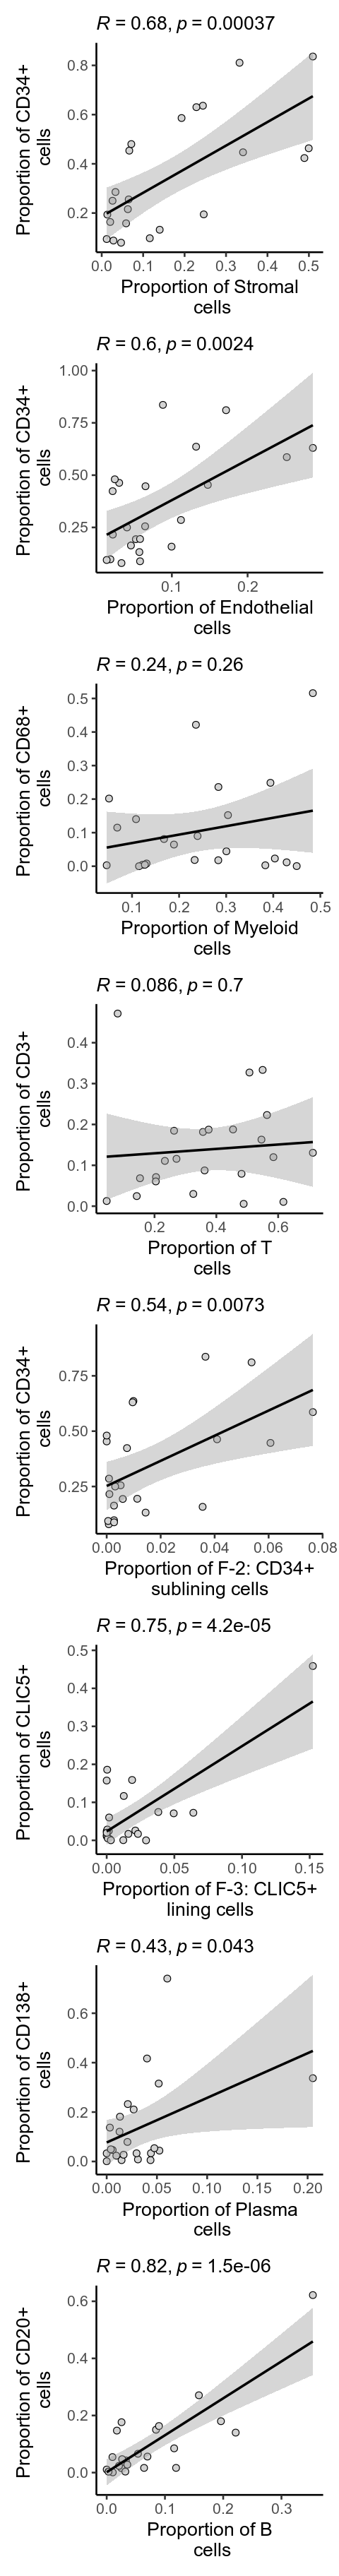

In [37]:
fig.size(3.8*8, 4)
plots[[1]] + plots[[2]] + plots[[3]] + plots[[4]] + plots[[5]] + plots[[6]] + plots[[7]] + plots[[8]] + 
plot_layout(ncol =1)

# End

In [38]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.7 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/mc1070/anaconda3/envs/R4.1.1Py3.9.7/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] patchwork_1.1.1    rstatix_0.7.0      ggtext_0.1.2       readxl_1.4.0      
 [5] RColorBrewer_1.1-3 pheatmap_1.0.12    forcats_0.5.1      stringr_1.4.0     
 [9] dplyr_1.1.0        purrr_0.3.4        readr_2.1.2        tidyr_1.2.0       
[1